In [123]:
from fastai.vision import *
import pandas as pd
from PIL import Image
from matplotlib.cbook import flatten

%reload_ext autoreload
%autoreload 2
%matplotlib inline

## data download

Let's get data from kaggle.

In [4]:
!mkdir ~/data/db_kaggle

In [16]:
cd /Users/ilyarudyak/data/db_kaggle/

/Users/ilyarudyak/data/db_kaggle


In [17]:
pwd

'/Users/ilyarudyak/data/db_kaggle'

In [18]:
!kaggle competitions download -c dog-breed-identification

  0%|                                                | 0.00/214k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 214k/214k [00:00<00:00, 4.51MB/s]
  0%|                                                | 0.00/281k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 281k/281k [00:00<00:00, 6.16MB/s]
100%|███████████████████████████████████████▉| 345M/346M [00:34<00:00, 11.1MB/s]
100%|████████████████████████████████████████| 346M/346M [00:34<00:00, 10.5MB/s]
100%|███████████████████████████████████████▉| 344M/345M [00:34<00:00, 10.9MB/s]
100%|████████████████████████████████████████| 345M/345M [00:34<00:00, 10.4MB/s]


In [26]:
ls *zip

labels.csv.zip             test.zip
sample_submission.csv.zip  train.zip


In [ ]:
! unzip \*.zip

In [35]:
! rm *.zip

In [36]:
ls

labels.csv             test/
sample_submission.csv  train/


In [43]:
! mv test/ valid/

In [44]:
ls

labels.csv             train/
sample_submission.csv  valid/


## first look

Let's have the first look at our data:

- `labels.csv` contains labels for each file in `train` folder; we have 120 unique labels (breeds);
- `sample_submission.csv` contains `scores(?)` for each class;
- we have about `10K` `train` and `valid` examples;

One of the main questions: what size of data should we use?

In [80]:
df = pd.read_csv('labels.csv')

In [81]:
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [52]:
df.breed.unique().shape

(120,)

In [47]:
df2 = pd.read_csv('sample_submission.csv')

In [48]:
df2.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


In [54]:
path = Path.home() / 'data/db_kaggle'
path_train, path_valid = path / 'train', path / 'valid'

In [56]:
len(path_train.ls()), len(path_valid.ls())

(10222, 10357)

In [64]:
path_train.ls()[:5]

[PosixPath('/Users/ilyarudyak/data/db_kaggle/train/84accc2dc9f5bb3ebee89fe1bf23639c.jpg'),
 PosixPath('/Users/ilyarudyak/data/db_kaggle/train/14cffe576239620f1733dfe487dbaa6f.jpg'),
 PosixPath('/Users/ilyarudyak/data/db_kaggle/train/cc93915e06bc55626a02af95006a48c2.jpg'),
 PosixPath('/Users/ilyarudyak/data/db_kaggle/train/6f9bac41b5be5ee6baecc9e7ef8f2c2a.jpg'),
 PosixPath('/Users/ilyarudyak/data/db_kaggle/train/64dd586a1d08937d20618233df2e5dbc.jpg')]

In [58]:
[Image.open(p).size for p in path_train.ls()[:10]]

[(500, 430),
 (400, 300),
 (272, 350),
 (500, 400),
 (500, 375),
 (375, 500),
 (516, 440),
 (375, 500),
 (500, 375),
 (425, 319)]

## convert to `ImageDataBunch`

Let's now try to convert our data into `ImageDataBunch`. Looks like we still can use a factory method - `from_csv()`:

>Before any work can be done a dataset needs to be converted into a DataBunch object, and in the case of the computer vision data - specifically into an ImageDataBunch subclass.
This is done with the help of data block API and the ImageList class and its subclasses.
However, there is also a group of shortcut methods provided by ImageDataBunch which reduce the multiple stages of the data block API, into a single wrapper method.

### example of `from_csv()`

Let's look at an example usage of `from_csv()`. As we can see the format of `csv` file is slightly different (name of the file includes `path` and `extension`).

In [151]:
path_mnist = untar_data(URLs.MNIST_SAMPLE)

In [152]:
path_mnist

PosixPath('/Users/ilyarudyak/.fastai/data/mnist_sample')

In [153]:
path_mnist.ls()

[PosixPath('/Users/ilyarudyak/.fastai/data/mnist_sample/valid'),
 PosixPath('/Users/ilyarudyak/.fastai/data/mnist_sample/labels.csv'),
 PosixPath('/Users/ilyarudyak/.fastai/data/mnist_sample/train')]

In [154]:
(path_mnist / 'train').ls()

[PosixPath('/Users/ilyarudyak/.fastai/data/mnist_sample/train/7'),
 PosixPath('/Users/ilyarudyak/.fastai/data/mnist_sample/train/3')]

Let's fix the number of training examples.

In [155]:
len((path_mnist / 'train/3').ls()), len((path_mnist / 'train/7').ls())

(6131, 6265)

In [156]:
len((path_mnist / 'train/3').ls()) + len((path_mnist / 'train/7').ls())

12396

In [157]:
len(list((path_mnist / 'train').glob('**/*')))

12398

In [158]:
len(list((path_mnist / 'train').glob('*/*')))

12396

In [159]:
list((path_mnist / 'train').glob('**/*'))[:5]

[PosixPath('/Users/ilyarudyak/.fastai/data/mnist_sample/train/7'),
 PosixPath('/Users/ilyarudyak/.fastai/data/mnist_sample/train/3'),
 PosixPath('/Users/ilyarudyak/.fastai/data/mnist_sample/train/7/30224.png'),
 PosixPath('/Users/ilyarudyak/.fastai/data/mnist_sample/train/7/27758.png'),
 PosixPath('/Users/ilyarudyak/.fastai/data/mnist_sample/train/7/29775.png')]

In [160]:
list((path_mnist / 'train').glob('*/*'))[:5]

[PosixPath('/Users/ilyarudyak/.fastai/data/mnist_sample/train/7/30224.png'),
 PosixPath('/Users/ilyarudyak/.fastai/data/mnist_sample/train/7/27758.png'),
 PosixPath('/Users/ilyarudyak/.fastai/data/mnist_sample/train/7/29775.png'),
 PosixPath('/Users/ilyarudyak/.fastai/data/mnist_sample/train/7/26446.png'),
 PosixPath('/Users/ilyarudyak/.fastai/data/mnist_sample/train/7/15932.png')]

In [62]:
dfm = pd.read_csv(path_mnist / 'labels.csv')

In [63]:
dfm.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [161]:
data_mnist = ImageDataBunch.from_csv(path_mnist, 
                                     ds_tfms=get_transforms(do_flip=False), 
                                     size=28,
                                     bs=8,
                                     num_workers=0)

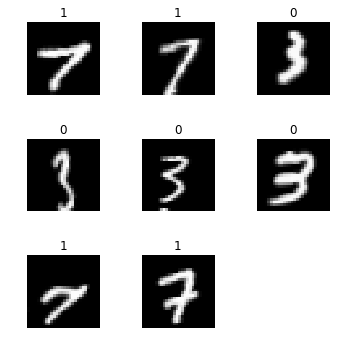

In [162]:
data_mnist.show_batch(rows=3, figsize=(5,5))

That's difficult to understand. General comment - it's not really possible to use before reading its source code.

In [163]:
len(data_mnist.train_ds)

11548

In [164]:
len(data_mnist.valid_ds)

2886

In [165]:
len(data_mnist.train_ds) + len(data_mnist.valid_ds)

14434

### actual data

In [82]:
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [83]:
def add_path(s):
    return 'train/' + s + '.jpg'

df.id = df.id.apply(add_path)

In [84]:
df.head()

,id,breed
0,train/000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,train/001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,train/00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,train/0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


In [85]:
path

PosixPath('/Users/ilyarudyak/data/db_kaggle')

In [86]:
df.to_csv(path / 'labels.csv', index=False)

In [87]:
! head /Users/ilyarudyak/data/db_kaggle/labels.csv

id,breed
train/000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
train/001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
train/001cdf01b096e06d78e9e5112d419397.jpg,pekinese
train/00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
train/0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever
train/002211c81b498ef88e1b40b9abf84e1d.jpg,bedlington_terrier
train/00290d3e1fdd27226ba27a8ce248ce85.jpg,bedlington_terrier
train/002a283a315af96eaea0e28e7163b21b.jpg,borzoi
train/003df8b8a8b05244b1d920bb6cf451f9.jpg,basenji


In [89]:
data = ImageDataBunch.from_csv(path,
                               csv_labels='labels.csv',
                               ds_tfms=get_transforms(),
                               size=224, 
                               num_workers=0)

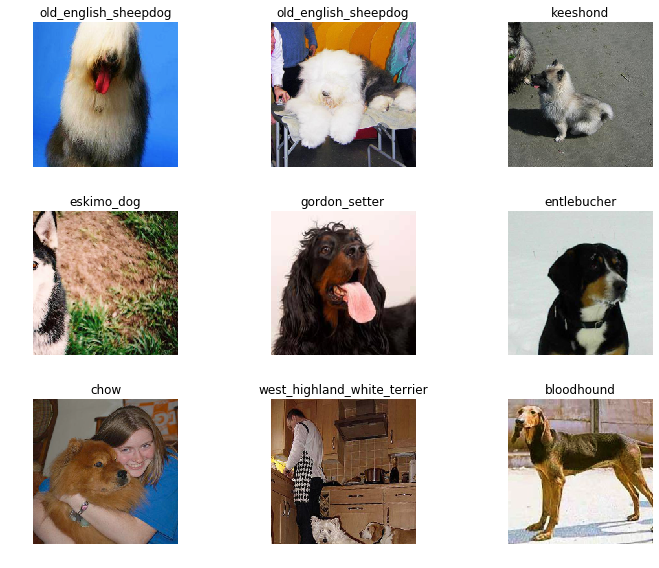

In [90]:
data.show_batch(rows=3, figsize=(10,8))